<p><span style="font-size: 16pt;">Worked example isochrone maps to GeoDataFrame</span></p>
<p>This is a worked example we expand on the previous exemple that commes from <a href="https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb">https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb</a>&nbsp;we now export the isochrones to GeoDataframe files to be able ot export shapes to different maps, eventually we could plot the shapes of all isochrones on a map of the whole country</p>

In [1]:
import osmnx as ox, networkx as nx, geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, mapping
from descartes import PolygonPatch
ox.config(log_console=True, use_cache=True)

In [2]:
# configure the place, network type, trip times, and travel speed
luxembourg_central_station = (49.5999681, 6.1342493)
network_type = 'walk'
trip_times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] #in minutes, we could make a differernt polygon for each minute
travel_speed = 4.5 #walking speed in km/hour

In [3]:
# download the street network
G = ox.graph_from_point(luxembourg_central_station, distance=1250, network_type=network_type)

In [4]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

In [5]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [6]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

In [7]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

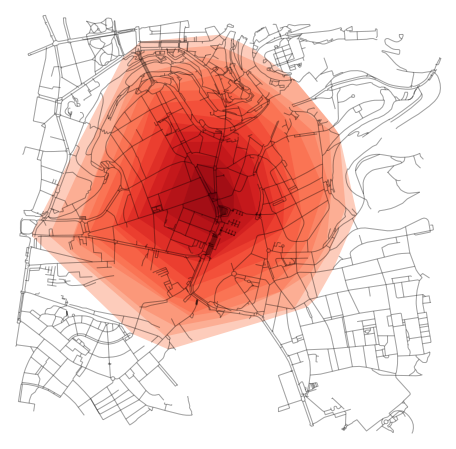

In [8]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

<p><span style="font-size: 16pt;">We now have shapes of isochrones that match node values</span></p>
<p>Now we have to find which nodes match with those polygon shapes</p>

In [9]:
mapping(isochrone_polys[0])

{'type': 'Polygon',
 'coordinates': (((292575.4782030785, 5497329.3063479215),
   (292365.2554784736, 5497422.504883383),
   (291760.095105301, 5498024.262892361),
   (291758.21187150746, 5498047.611641202),
   (292302.90787804197, 5499126.559449185),
   (292409.0812770213, 5499227.115210414),
   (292889.3970736285, 5499270.286599182),
   (292969.73076251545, 5499241.59789318),
   (293086.45665064966, 5499183.6610414125),
   (293335.1374054475, 5498993.914196095),
   (293570.0899898636, 5498704.818319297),
   (293605.27641589276, 5498651.696973181),
   (293711.41778229823, 5498162.017898161),
   (293567.93206416344, 5497821.334187215),
   (293472.7035660724, 5497648.418728848),
   (293409.55820003105, 5497588.282661938),
   (293144.5191994946, 5497500.977835562),
   (292612.465434392, 5497336.788551088),
   (292575.4782030785, 5497329.3063479215)),)}

In [10]:
mapping(isochrone_polys[0])['coordinates']

(((292575.4782030785, 5497329.3063479215),
  (292365.2554784736, 5497422.504883383),
  (291760.095105301, 5498024.262892361),
  (291758.21187150746, 5498047.611641202),
  (292302.90787804197, 5499126.559449185),
  (292409.0812770213, 5499227.115210414),
  (292889.3970736285, 5499270.286599182),
  (292969.73076251545, 5499241.59789318),
  (293086.45665064966, 5499183.6610414125),
  (293335.1374054475, 5498993.914196095),
  (293570.0899898636, 5498704.818319297),
  (293605.27641589276, 5498651.696973181),
  (293711.41778229823, 5498162.017898161),
  (293567.93206416344, 5497821.334187215),
  (293472.7035660724, 5497648.418728848),
  (293409.55820003105, 5497588.282661938),
  (293144.5191994946, 5497500.977835562),
  (292612.465434392, 5497336.788551088),
  (292575.4782030785, 5497329.3063479215)),)

In [11]:
mapping(isochrone_polys[1])['coordinates'][0][0]

(292561.3851221783, 5497408.600888142)

In [12]:
# We create a GeoDataFrame from the UTM graph
nodes2, _ = ox.graph_to_gdfs(G)
nodes2

,highway,lat,lon,osmid,ref,x,y,geometry
35348492,NaN,49.598262,6.132349,35348492,NaN,292790.176624,5.497916e+06,POINT (292790.1766243548 5497915.565167701)
35348505,NaN,49.606315,6.130158,35348505,NaN,292666.024648,5.498817e+06,POINT (292666.0246476262 5498816.702088248)
35348506,NaN,49.605448,6.131084,35348506,NaN,292729.245169,5.498718e+06,POINT (292729.2451694452 5498717.799437888)
647495720,NaN,49.609593,6.128619,647495720,NaN,292568.770302,5.499185e+06,POINT (292568.7703020406 5499185.257326025)
647495726,NaN,49.609485,6.128671,647495726,NaN,292572.059659,5.499173e+06,POINT (292572.0596589285 5499173.087171623)
3978141747,NaN,49.606949,6.135032,3978141747,NaN,293020.812638,5.498874e+06,POINT (293020.8126379559 5498873.775916347)
647495747,NaN,49.609392,6.130052,647495747,NaN,292671.467959,5.499159e+06,POINT (292671.4679591135 5499158.960353763)
1374336341,NaN,49.597714,6.138954,1374336341,NaN,293265.054198,5.497836e+06,POINT (293265.0541979132 5497836.392366599)
2175819876,NaN,49.595547,6.133603,2175819876,NaN,292869.265309,5.497610e+06,POINT (292869.2653092971 5497610.225047253)
2175819880,NaN,49.595682,6.133653,2175819880,NaN,292873.444091,5.497625e+06,POINT (292873.4440907449 5497625.126804154)


<p><span style="font-size: 16pt;">We can now look for the GeoDataFrame keys that match the polygon mappings</span></p>
<p>With those keys we can use the method osmnx.plot.plot_shape <a href="https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_shape">https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_shape</a>&nbsp;the great thing about this method is that it allows us to plot the shapes on other maps that contain the nodes with that unique key value</p>